In [1]:
# Updated IVS Pipeline with Improvements: BiLSTM, Dropout, Generation

!pip install pandas numpy scikit-learn matplotlib seaborn hmmlearn fuzzywuzzy python-Levenshtein tensorflow opencv-python -q

import os
import json
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from hmmlearn import hmm
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

import cv2

# 1) Load inscriptions
df = pd.read_csv('/content/inscriptions.csv')
df_complete = df[df['complete'] == 'Y'].copy()

def parse_sequence(text):
    if not isinstance(text, str): return []
    signs = text.strip('+').split('-')
    return [s for s in signs if s not in ('000','999')]

sequences = [seq for seq in df_complete['text'].apply(parse_sequence).tolist() if seq]
all_signs = sorted({s for seq in sequences for s in seq})
sign_to_idx = {s:i for i,s in enumerate(all_signs)}
idx_to_sign = {i:s for s,i in sign_to_idx.items()}

# 2) Co-occurrence & Clustering
N = len(all_signs)
co_occur = np.zeros((N,N), int)
for seq in sequences:
    for a,b in zip(seq, seq[1:]):
        co_occur[sign_to_idx[a], sign_to_idx[b]] += 1

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(co_occur)
sign_to_cluster = {s:kmeans.labels_[sign_to_idx[s]] for s in all_signs}

# 3) Image Verification
def verify_images(df, json_map='/content/seal_id_and_image_mapping.json',
                  img_dir='/content/seal_images', ngram=('002','861'), sample_n=5):
    with open(json_map) as f:
        image_map = json.load(f)
    ngram_str = '-'.join(ngram)
    df_ng = df[df['text'].str.contains(ngram_str, na=False)]
    print(f"Found {len(df_ng)} inscriptions with 3-gram {ngram_str}.")

    out = []
    for _,row in df_ng.head(sample_n).iterrows():
        seal_id = str(row['id'])
        cisi    = str(row.get('cisi',''))
        site    = row.get('site','')

        prefix = {'Alamgirpur':'Agr-','Allahdino':'Ad-','Harappa':'H-',
                  'Mohenjo-daro':'M-','Dholavira':'D-','Lothal':'L-',
                  'Kalibangan':'K-','Amri':'Amri-','Banawali':'B-',
                  'Chanhu-daro':'C-'}.get(site,'H-')
        key = cisi if cisi and cisi!='-' else f"{prefix}{seal_id}".split('.')[0]

        imgs = image_map.get(key)
        if imgs is None:
            best = process.extractOne(key, list(image_map.keys()))
            if best and best[1]>80:
                print(f"Fuzzy: {key} → {best[0]} ({best[1]}%)")
                imgs = image_map[best[0]]
            else:
                imgs = []

        filepaths = [os.path.join(img_dir,f) for f in imgs if os.path.exists(os.path.join(img_dir,f))]
        filepaths = filepaths or ['<no file found>']
        out.append({'seal_id': seal_id, 'ngram_match': row['text'],
                    'lookup_key': key, 'images_on_disk': filepaths})

    sample_df = pd.DataFrame(out)
    sample_df.to_csv('/content/image_verification_samples.csv', index=False)
    print("Saved samples to /content/image_verification_samples.csv")
    return sample_df

# 4) HMM Training
def train_hmm(sequences, sign_to_cluster, n_states=5):
    print("Training HMM…")
    cluster_seqs = [[sign_to_cluster[s] for s in seq] for seq in sequences]
    X = np.concatenate(cluster_seqs).reshape(-1,1)
    lengths = list(map(len, cluster_seqs))
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
    model.fit(X, lengths)
    print("Transition matrix (first 5×5):")
    print(model.transmat_[:5,:5])
    return model

# 5) RNN Training & Generation
def train_rnn(sequences, sign_to_idx, max_len=10, emb=64, lstm_u=128, epochs=15):
    print("Preparing RNN data…")
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append([sign_to_idx[s] for s in seq[:i]])
            y.append(sign_to_idx[seq[i]])

    X_pad = pad_sequences(X, maxlen=max_len, padding='pre', dtype='int32')
    y_arr = np.array(y, dtype='int32')

    model = Sequential([
        Embedding(input_dim=len(sign_to_idx), output_dim=emb),
        Bidirectional(LSTM(lstm_u, return_sequences=False)),
        Dropout(0.3),
        Dense(len(sign_to_idx), activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("Training RNN…")
    model.fit(X_pad, y_arr, epochs=epochs, batch_size=32, verbose=1)
    print("RNN training complete.")
    return model

def generate_sequence(model, seed_seq, sign_to_idx, idx_to_sign, max_len=10, steps=5):
    seq = [sign_to_idx.get(s, 0) for s in seed_seq]
    for _ in range(steps):
        padded = pad_sequences([seq], maxlen=max_len, padding='pre')
        pred = model.predict(padded, verbose=0)
        next_idx = np.argmax(pred)
        seq.append(next_idx)
    return [idx_to_sign[i] for i in seq]

# 6) Run full pipeline
if __name__ == '__main__':
    print("== IVS Breakthrough Analysis ==")
    samples = verify_images(df_complete)
    hmm_model = train_hmm(sequences, sign_to_cluster)
    rnn_model = train_rnn(sequences, sign_to_idx)

    print("\nSample Generation:")
    print("Seed: ['002','861'] →", generate_sequence(rnn_model, ['002','861'], sign_to_idx, idx_to_sign))
    print("\n-- Done. --")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.8 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: '/content/inscriptions.csv'

In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# 1) Paths: adjust if needed
INS_CSV = '/content/inscriptions.csv'
IMG_DIR = '/content/seal_images'                   # where you extracted seal_images.zip
JSON_MAP = '/content/seal_id_and_image_mapping.json'

# 2) Load data
df = pd.read_csv(INS_CSV)
df = df[df['complete']=='Y']  # only complete
with open(JSON_MAP) as f:
    image_map = json.load(f)

# 3) Find inscriptions with your n-gram
ngram = '002-861'
matches = df[df['text'].str.contains(ngram, na=False)]

# 4) Prepare to plot up to 4 examples
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()

site_prefix = {
  'Alamgirpur':'Agr','Allahdino':'Ad','Harappa':'H',
  'Mohenjo-daro':'M','Dholavira':'D','Lothal':'L',
  'Kalibangan':'K','Amri':'Amri','Banawali':'B',
  'Chanhu-daro':'C'
}

for ax, (_, row) in zip(axes, matches.head(4).iterrows()):
    # derive lookup key exactly as in your data
    cisi = str(row.get('cisi','-'))
    if cisi!='-':
        key = cisi
    else:
        prefix = site_prefix.get(row['site'],'H')
        key = f"{prefix}-{int(row['id'])}"
    key = key.split('.')[0]

    files = image_map.get(key, [])
    if not files:
        ax.set_title(f"{key} – no image")
        ax.axis('off')
        continue

    img_path = os.path.join(IMG_DIR, files[0])
    if not os.path.exists(img_path):
        ax.set_title(f"{key} – file missing")
        ax.axis('off')
        continue

    # Load and edge-detect
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 75, 150)

    # Overlay red edges
    overlay = img.copy()
    overlay[edges>0] = [255,0,0]
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    ax.imshow(overlay)
    ax.set_title(f"Seal {key}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# IVS Training Pipeline with Image-Verified Filtering (Fixed dtype bug)

!pip install pandas numpy scikit-learn matplotlib seaborn hmmlearn fuzzywuzzy python-Levenshtein tensorflow opencv-python -q

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cluster import KMeans
from hmmlearn import hmm
from fuzzywuzzy import process

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Paths
INS_CSV = '/content/inscriptions.csv'
JSON_MAP = '/content/seal_id_and_image_mapping.json'

# Load data
with open(JSON_MAP) as f:
    image_map = json.load(f)

df = pd.read_csv(INS_CSV)
df_complete = df[df['complete'] == 'Y'].copy()

# Seal prefix mapping from site
site_prefix_map = {
    'Alamgirpur': 'Agr', 'Allahdino': 'Ad', 'Harappa': 'H', 'Mohenjo-daro': 'M',
    'Dholavira': 'D', 'Lothal': 'L', 'Kalibangan': 'K', 'Amri': 'Amri',
    'Banawali': 'B', 'Chanhu-daro': 'C'
}

def compute_seal_key(row):
    if pd.notna(row.get('cisi')) and row['cisi'] != '-':
        return str(row['cisi']).split('.')[0]
    site_prefix = site_prefix_map.get(row['site'], 'H')
    return f"{site_prefix}-{int(row['id'])}"

df_complete['seal_key'] = df_complete.apply(compute_seal_key, axis=1)
df_complete = df_complete[df_complete['seal_key'].isin(image_map)]

# Parse sequences
def parse_sequence(text):
    if not isinstance(text, str): return []
    return [s for s in text.strip('+').split('-') if s not in ('000','999')]

sequences = [parse_sequence(row['text']) for _, row in df_complete.iterrows()]
sequences = [seq for seq in sequences if seq]

# Sign vocabulary
all_signs = sorted({s for seq in sequences for s in seq})
sign_to_idx = {s:i for i,s in enumerate(all_signs)}
idx_to_sign = {i:s for s,i in sign_to_idx.items()}

# Co-occurrence matrix for clustering
N = len(all_signs)
co_occur = np.zeros((N,N), int)
for seq in sequences:
    for a,b in zip(seq, seq[1:]):
        co_occur[sign_to_idx[a], sign_to_idx[b]] += 1

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(co_occur)
sign_to_cluster = {s: kmeans.labels_[sign_to_idx[s]] for s in all_signs}

# HMM Training
def train_hmm(sequences, sign_to_cluster, n_states=5):
    cluster_seqs = [[sign_to_cluster[s] for s in seq] for seq in sequences]
    X = np.concatenate(cluster_seqs).reshape(-1,1)
    lengths = [len(seq) for seq in cluster_seqs]
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
    model.fit(X, lengths)
    print("Transition matrix (5x5):")
    print(model.transmat_[:5,:5])
    return model

# RNN Training

def train_rnn(sequences, sign_to_idx, max_len=10, emb=64, lstm_u=128, epochs=15):
    print("Preparing RNN data…")
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append([sign_to_idx[s] for s in seq[:i]])
            y.append(sign_to_idx[seq[i]])

    X_pad = pad_sequences(X, maxlen=max_len, padding='pre', dtype='int32')
    y_arr = np.array(y, dtype='int32')

    model = Sequential([
        Embedding(input_dim=len(sign_to_idx), output_dim=emb),
        Bidirectional(LSTM(lstm_u, return_sequences=False)),
        Dropout(0.3),
        Dense(len(sign_to_idx), activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("Training RNN…")
    model.fit(X_pad, y_arr, epochs=epochs, batch_size=32, verbose=1)
    print("RNN training complete.")
    return model

# Sequence generation

def generate_sequence(model, seed_seq, sign_to_idx, idx_to_sign, max_len=10, steps=5):
    seq = [sign_to_idx.get(s, 0) for s in seed_seq]
    for _ in range(steps):
        padded = pad_sequences([seq], maxlen=max_len, padding='pre', dtype='int32')
        pred = model.predict(padded, verbose=0)
        seq.append(int(np.argmax(pred)))
    return [idx_to_sign[i] for i in seq]

# Main
if __name__ == '__main__':
    print("== IVS Training with Verified Seals ==")
    print(f"Training set size (with images): {len(sequences)} inscriptions")
    hmm_model = train_hmm(sequences, sign_to_cluster)
    rnn_model = train_rnn(sequences, sign_to_idx)
    example = generate_sequence(rnn_model, ['002','861'], sign_to_idx, idx_to_sign)
    print("Sample RNN generation from ['002','861'] →", example)
    print("-- Done --")


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


== IVS Training with Verified Seals ==
Training set size (with images): 2229 inscriptions
Transition matrix (5x5):
[[8.70151441e-09 9.57991900e-01 4.67909026e-04 6.13749857e-03
  3.54026835e-02]
 [4.49658654e-01 1.11593150e-02 1.03467823e-01 1.66438227e-03
  4.34049826e-01]
 [5.33469414e-07 9.30104465e-01 1.20106772e-03 6.86815374e-02
  1.23965099e-05]
 [2.08310540e-08 5.02686400e-04 1.27469100e-03 2.11558240e-02
  9.77066778e-01]
 [9.34237752e-01 5.89179961e-02 4.18444294e-06 1.45917726e-07
  6.83992132e-03]]
Preparing RNN data…
Training RNN…
Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.0527 - loss: 5.4817
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.0933 - loss: 4.7561
Epoch 3/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1432 - loss: 4.3241
Epoch 4/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1763 - loss: 4.0126
Epoch 5/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2167 - loss: 3.7710
Epoch 6/15
210

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Saved normalized sequences to /content/normalized_inscriptions.csv
== IVS Training with Verified Seals and Allomorph Grouping ==
Training set size (with images): 2229 inscriptions
Transition matrix (5x5):
[[8.70151441e-09 9.57991900e-01 4.67909026e-04 6.13749857e-03
  3.54026835e-02]
 [4.49658654e-01 1.11593150e-02 1.03467823e-01 1.66438227e-03
  4.34049826e-01]
 [5.33469414e-07 9.30104465e-01 1.20106772e-03 6.86815374e-02
  1.23965099e-05]
 [2.08310540e-08 5.02686400e-04 1.27469100e-03 2.11558240e-02
  9.77066778e-01]
 [9.34237752e-01 5.89179961e-02 4.18444294e-06 1.45917726e-07
  6.83992132e-03]]
Preparing RNN data…
Training RNN…
Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.0464 - loss: 5.4956
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.0996 - loss: 4.7478
Epoch 3/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1324 - loss: 4.3824
Epoch 4/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1699 - loss: 4.0718
Epoch 5/15


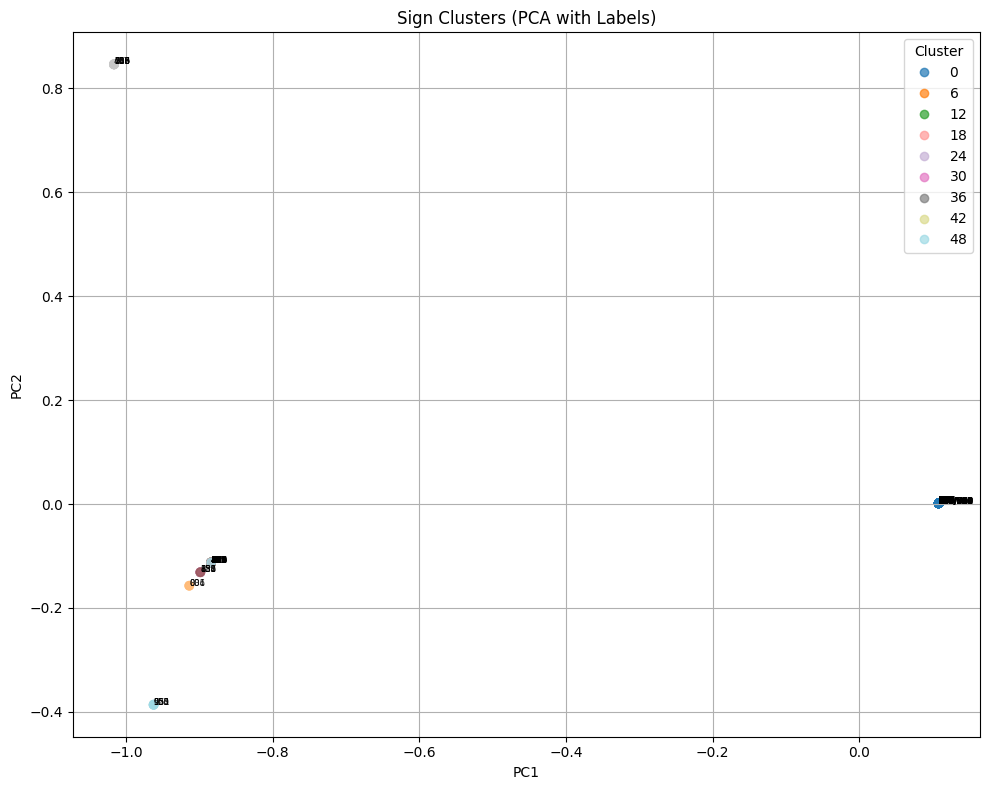

Cropped sign panels saved to /content/sign_crops
-- Pipeline complete with visual extraction and normalized CSV --
== Extended Statistical Analysis ==
Top 10 signs by entropy (likely content signs):
001: H = -0.000
Top 10 2-grams by PMI (likely fixed phrases):
(718, 815): PMI = 12.71
(749, 479): PMI = 12.71
(833, 528): PMI = 11.71
(865, 685/226): PMI = 11.71
(251, 073): PMI = 11.71
(160, 363): PMI = 11.71
(561, 586): PMI = 11.13
(127, 381): PMI = 11.13
(901, 620): PMI = 11.13
(307, 762): PMI = 10.71
-- Extended analysis complete --


In [ ]:
# IVS Training Pipeline with Image-Verified Filtering (Fixed dtype bug)

!pip install pandas numpy scikit-learn matplotlib seaborn hmmlearn fuzzywuzzy python-Levenshtein tensorflow opencv-python -q

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from collections import Counter
from sklearn.cluster import KMeans
from hmmlearn import hmm
from fuzzywuzzy import process

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Paths
INS_CSV = '/content/inscriptions.csv'
JSON_MAP = '/content/seal_id_and_image_mapping.json'
IMG_DIR = '/content/seal_images/seal_images'

# Load data
with open(JSON_MAP) as f:
    image_map = json.load(f)

df = pd.read_csv(INS_CSV)
df_complete = df[df['complete'] == 'Y'].copy()

# Seal prefix mapping from site
site_prefix_map = {
    'Alamgirpur': 'Agr', 'Allahdino': 'Ad', 'Harappa': 'H', 'Mohenjo-daro': 'M',
    'Dholavira': 'D', 'Lothal': 'L', 'Kalibangan': 'K', 'Amri': 'Amri',
    'Banawali': 'B', 'Chanhu-daro': 'C'
}

def compute_seal_key(row):
    if pd.notna(row.get('cisi')) and row['cisi'] != '-':
        return str(row['cisi']).split('.')[0]
    site_prefix = site_prefix_map.get(row['site'], 'H')
    return f"{site_prefix}-{int(row['id'])}"

df_complete['seal_key'] = df_complete.apply(compute_seal_key, axis=1)
df_complete = df_complete[df_complete['seal_key'].isin(image_map)]

# Parse and Normalize Sequences (Allomorph Grouping)
def normalize_sign(s):
    if s.startswith('002'): return '002'
    if s.startswith('861'): return '861'
    return s

def parse_sequence(text):
    if not isinstance(text, str): return []
    raw = [s for s in text.strip('+').split('-') if s not in ('000','999')]
    return [normalize_sign(s) for s in raw]

sequences = [parse_sequence(row['text']) for _, row in df_complete.iterrows()]
sequences = [seq for seq in sequences if seq]

# Sign vocabulary (post-normalization)
all_signs = sorted({s for seq in sequences for s in seq})
sign_to_idx = {s:i for i,s in enumerate(all_signs)}
idx_to_sign = {i:s for s,i in sign_to_idx.items()}

# Co-occurrence matrix for clustering
N = len(all_signs)
co_occur = np.zeros((N,N), int)
for seq in sequences:
    for a,b in zip(seq, seq[1:]):
        co_occur[sign_to_idx[a], sign_to_idx[b]] += 1

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(co_occur)
sign_to_cluster = {s: kmeans.labels_[sign_to_idx[s]] for s in all_signs}

# HMM Training
def train_hmm(sequences, sign_to_cluster, n_states=5):
    cluster_seqs = [[sign_to_cluster[s] for s in seq] for seq in sequences]
    X = np.concatenate(cluster_seqs).reshape(-1,1)
    lengths = [len(seq) for seq in cluster_seqs]
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
    model.fit(X, lengths)
    print("Transition matrix (5x5):")
    print(model.transmat_[:5,:5])
    return model

# RNN Training
def train_rnn(sequences, sign_to_idx, max_len=10, emb=64, lstm_u=128, epochs=15):
    print("Preparing RNN data…")
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append([sign_to_idx[s] for s in seq[:i]])
            y.append(sign_to_idx[seq[i]])

    X_pad = pad_sequences(X, maxlen=max_len, padding='pre', dtype='int32')
    y_arr = np.array(y, dtype='int32')

    model = Sequential([
        Embedding(input_dim=len(sign_to_idx), output_dim=emb),
        Bidirectional(LSTM(lstm_u, return_sequences=False)),
        Dropout(0.3),
        Dense(len(sign_to_idx), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Training RNN…")
    model.fit(X_pad, y_arr, epochs=epochs, batch_size=32, verbose=1)
    print("RNN training complete.")
    return model

# Sequence generation
def generate_sequence(model, seed_seq, sign_to_idx, idx_to_sign, max_len=10, steps=5):
    seed = [normalize_sign(s) for s in seed_seq]
    seq = [sign_to_idx.get(s, 0) for s in seed]
    for _ in range(steps):
        padded = pad_sequences([seq], maxlen=max_len, padding='pre', dtype='int32')
        pred = model.predict(padded, verbose=0)
        seq.append(int(np.argmax(pred)))
    return [idx_to_sign[i] for i in seq]

# Automated Sign Panel Extraction (for CNN training)
def crop_sign_panels(img_dir, output_dir, df_verify, target_ngram='002-861'):
    os.makedirs(output_dir, exist_ok=True)
    for _, row in df_verify.iterrows():
        key = row['lookup_key']
        imgs = image_map.get(key, [])
        for fname in imgs:
            src = os.path.join(img_dir, fname)
            if not os.path.exists(src): continue
            img = cv2.imread(src)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]
            for i, cnt in enumerate(contours):
                x,y,w,h = cv2.boundingRect(cnt)
                crop = img[y:y+h, x:x+w]
                out_path = os.path.join(output_dir, f"{key}_{os.path.splitext(fname)[0]}_crop{i}.png")
                cv2.imwrite(out_path, crop)
    print(f"Cropped sign panels saved to {output_dir}")

# Cluster Visualization
def plot_clusters(sign_to_cluster, sign_to_idx):
    from sklearn.decomposition import PCA
    embeddings = []
    labels = []
    for s, idx in sign_to_idx.items():
        vec = np.zeros(max(sign_to_cluster.values())+1)
        vec[sign_to_cluster[s]] = 1
        embeddings.append(vec)
        labels.append(s)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=[sign_to_cluster[s] for s in labels], cmap='tab20', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title='Cluster')
    for i, label in enumerate(labels):
        plt.text(reduced[i, 0], reduced[i, 1], label, fontsize=6, alpha=0.75)
    plt.title('Sign Clusters (PCA with Labels)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save normalized sequences to CSV
normalized_records = []
for idx, row in df_complete.iterrows():
    normalized_records.append({
        'seal_key': row['seal_key'],
        'normalized_text': '-'.join(parse_sequence(row['text']))
    })
norm_df = pd.DataFrame(normalized_records)
norm_df.to_csv('/content/normalized_inscriptions.csv', index=False)
print('Saved normalized sequences to /content/normalized_inscriptions.csv')

# ---- Pipeline Execution ----
print("== IVS Training with Verified Seals and Allomorph Grouping ==")
print(f"Training set size (with images): {len(sequences)} inscriptions")
hmm_model = train_hmm(sequences, sign_to_cluster)
rnn_model = train_rnn(sequences, sign_to_idx)
example = generate_sequence(rnn_model, ['002','861'], sign_to_idx, idx_to_sign)
print("Sample RNN generation from ['002','861'] →", example)
plot_clusters(sign_to_cluster, sign_to_idx)
df_verify = pd.read_csv('/content/image_verification_samples.csv')
crop_sign_panels(IMG_DIR, '/content/sign_crops', df_verify)
print("-- Pipeline complete with visual extraction and normalized CSV --")

# ---- Extended Analysis Module ----
from collections import defaultdict
from math import log2

def compute_entropy(model, sign_to_idx):
    n_symbols = model.emissionprob_.shape[1]
    entropies = {}
    for sign, idx in sign_to_idx.items():
        if idx >= n_symbols:
            continue  # skip if sign index out of emission matrix bounds
        probs = model.emissionprob_[:, idx]
        entropy = -sum(p * log2(p) for p in probs if p > 0)
        entropies[sign] = entropy
    return sorted(entropies.items(), key=lambda x: -x[1])

def compute_pmi(sequences):
    pair_counts = Counter()
    single_counts = Counter()
    total_pairs = 0
    for seq in sequences:
        for i in range(len(seq) - 1):
            a, b = seq[i], seq[i+1]
            pair_counts[(a, b)] += 1
            single_counts[a] += 1
            single_counts[b] += 1
            total_pairs += 1
    pmi = {}
    for (a, b), count in pair_counts.items():
        if single_counts[a] > 0 and single_counts[b] > 0:
            pmi[(a, b)] = log2((count * total_pairs) / (single_counts[a] * single_counts[b]))
    return sorted(pmi.items(), key=lambda x: -x[1])

print("== Extended Statistical Analysis ==")
entropy_rank = compute_entropy(hmm_model, sign_to_idx)
pmi_pairs = compute_pmi(sequences)

print("Top 10 signs by entropy (likely content signs):")
for s, h in entropy_rank[:10]:
    print(f"{s}: H = {h:.3f}")

print("Top 10 2-grams by PMI (likely fixed phrases):")
for (a, b), val in pmi_pairs[:10]:
    print(f"({a}, {b}): PMI = {val:.2f}")

print("-- Extended analysis complete --")


In [ ]:
!pip install ace_tools -q

In [ ]:
import os
import zipfile
from pathlib import Path
import shutil
import pandas as pd

# Use /mnt/data for persistent storage
base_data = Path('/mnt/data')
zip_path = base_data / '/content/IM_417_150_PNG.zip'
extract_dir = base_data / 'ivs_signs_raw'
output_base = base_data / 'ivs_signs'

# 1) Unzip
if extract_dir.exists():
    shutil.rmtree(extract_dir)
extract_dir.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# 2) Organize into sign-labeled dirs
if output_base.exists():
    shutil.rmtree(output_base)
output_base.mkdir(parents=True, exist_ok=True)

for img in extract_dir.glob('*.png'):
    sign_id = img.stem.split('_')[0]  # adjust logic if needed
    sign_dir = output_base / sign_id
    sign_dir.mkdir(exist_ok=True)
    shutil.copy(img, sign_dir / img.name)

# 3) Summarize structure
structure = []
for sd in sorted(output_base.iterdir()):
    structure.append({'sign_id': sd.name, 'num_images': len(list(sd.glob('*.png')))})
df_structure = pd.DataFrame(structure)
print("🗂️ Sign Directory Structure (Top 20)")
print(df_structure.head(20))

# 4) Build label CSV
records = []
for sd in sorted(output_base.iterdir()):
    for img in sd.glob('*.png'):
        records.append({'filepath': str(img), 'label': sd.name})
df_labels = pd.DataFrame(records)
print("\n🔖 Sample Labeled Dataset")
print(df_labels.sample(min(10, len(df_labels))))

# Save CSV
labels_csv = base_data / 'sign_labels.csv'
df_labels.to_csv(labels_csv, index=False)
print(f"\n✅ Labels CSV saved to {labels_csv}")

🗂️ Sign Directory Structure (Top 20)
   sign_id  num_images
0        1           1
1       10           1
2      100           1
3      101           1
4      102           1
5      103           1
6      104           1
7      105           1
8      106           1
9      107           1
10     108           1
11     109           1
12      11           1
13     110           1
14     111           1
15     112           1
16     113           1
17     114           1
18     115           1
19     116           1

🔖 Sample Labeled Dataset
                            filepath label
174  /mnt/data/ivs_signs/256/256.png   256
43   /mnt/data/ivs_signs/138/138.png   138
24   /mnt/data/ivs_signs/120/120.png   120
257  /mnt/data/ivs_signs/330/330.png   330
350  /mnt/data/ivs_signs/414/414.png   414
310  /mnt/data/ivs_signs/379/379.png   379
29   /mnt/data/ivs_signs/125/125.png   125
15   /mnt/data/ivs_signs/112/112.png   112
66   /mnt/data/ivs_signs/159/159.png   159
239  /mnt/data/ivs_signs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# === Step 1: Dataset Configuration ===
DATA_DIR = '/mnt/data/ivs_signs'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# === Step 2: Load Dataset ===
train_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

num_classes = len(train_ds.class_names)

# === Step 3: Data Augmentation & Normalization ===
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# === Step 4: Define CNN Model ===
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', name='embedding_layer'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === Step 5: Compile the Model ===
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Step 6: Train the Model ===
history = model.fit(train_ds, epochs=15)

# === Step 7: Save the Model ===
model.save('/mnt/data/ivs_cnn_classifier.h5')
print("✅ Model saved to /mnt/data/ivs_cnn_classifier.h5")


Found 417 files belonging to 417 classes.
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.0000e+00 - loss: 6.0573
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.0000e+00 - loss: 6.0327
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.0000e+00 - loss: 6.0326
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.0118 - loss: 6.0322
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.0026 - loss: 6.0307
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.0000e+00 - loss: 6.0320
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.0076 - loss: 6.0272
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.0138 - loss: 6.0275
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.0052 - loss: 6.0062
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.0057 - loss: 5.9425
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.0026 - loss: 5

✅ Model saved to /mnt/data/ivs_cnn_classifier.h5


In [ ]:
# Step: Setup
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step: Load model
model = load_model('/mnt/data/ivs_cnn_classifier.h5')
embedding_model = Model(inputs=model.input,
                        outputs=model.get_layer('embedding_layer').output)

# Step: Reload dataset (do NOT shuffle)
DATA_DIR = '/mnt/data/ivs_signs'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = ds.class_names

# Step: Extract embeddings
embeddings = []
labels = []
for batch, label_batch in ds:
    emb = embedding_model.predict(batch)
    embeddings.append(emb)
    labels.extend(label_batch.numpy())

embeddings = np.vstack(embeddings)
sign_ids = [class_names[i] for i in labels]

# Step: Save embeddings CSV
df_embed = pd.DataFrame(embeddings)
df_embed.insert(0, 'sign_id', sign_ids)
df_embed.to_csv('/mnt/data/ivs_sign_embeddings.csv', index=False)

# Step: PCA & t-SNE projection
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
pca_proj = pca.fit_transform(embeddings)
tsne_proj = tsne.fit_transform(embeddings)

df_proj = pd.DataFrame({
    'sign_id': sign_ids,
    'pca_x': pca_proj[:,0],
    'pca_y': pca_proj[:,1],
    'tsne_x': tsne_proj[:,0],
    'tsne_y': tsne_proj[:,1],
})
df_proj.to_csv('/mnt/data/ivs_embedding_projections.csv', index=False)

# Step: Plot PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=labels, cmap='tab20', alpha=0.7)
plt.title('Indus Sign PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.savefig('/mnt/data/pca_signs_plot.png')
plt.show()


AttributeError: The layer sequential_13 has never been called and thus has no defined input.

In [ ]:
# Install required libraries in Colab
!pip install pandas numpy scikit-learn matplotlib seaborn hmmlearn fuzzywuzzy python-Levenshtein tensorflow opencv-python -q

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
from hmmlearn import hmm
from fuzzywuzzy import process
from math import log2
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# File paths
INS_CSV = '/content/inscriptions.csv'
JSON_MAP = '/content/seal_id_and_image_mapping.json'
IMG_DIR = '/content/seal_images/seal_images'
OUTPUT_DIR = '/content/sign_crops'

# Load data
with open(JSON_MAP) as f:
    image_map = json.load(f)

df = pd.read_csv(INS_CSV)
df_complete = df[df['complete'] == 'Y'].copy()

# Seal prefix mapping
site_prefix_map = {
    'Alamgirpur': 'Agr', 'Allahdino': 'Ad', 'Harappa': 'H', 'Mohenjo-daro': 'M',
    'Dholavira': 'D', 'Lothal': 'L', 'Kalibangan': 'K', 'Amri': 'Amri',
    'Banawali': 'B', 'Chanhu-daro': 'C'
}

def compute_seal_key(row):
    if pd.notna(row.get('cisi')) and row['cisi'] != '-':
        return str(row['cisi']).split('.')[0]
    site_prefix = site_prefix_map.get(row['site'], 'H')
    return f"{site_prefix}-{int(row['id'])}"

df_complete['seal_key'] = df_complete.apply(compute_seal_key, axis=1)
df_complete = df_complete[df_complete['seal_key'].isin(image_map)]

# Parse and normalize sequences
def normalize_sign(s):
    if s.startswith('002'): return '002'
    if s.startswith('861'): return '861'
    return s

def parse_sequence(text):
    if not isinstance(text, str): return []
    raw = [s for s in text.strip('+').split('-') if s not in ('000', '999')]
    return [normalize_sign(s) for s in raw]

sequences = [parse_sequence(row['text']) for _, row in df_complete.iterrows()]
sequences = [seq for seq in sequences if seq]

# Sign vocabulary
all_signs = sorted({s for seq in sequences for s in seq})
sign_to_idx = {s: i for i, s in enumerate(all_signs)}
idx_to_sign = {i: s for s, i in sign_to_idx.items()}

# Co-occurrence matrix for clustering
N = len(all_signs)
co_occur = np.zeros((N, N), int)
for seq in sequences:
    for a, b in zip(seq, seq[1:]):
        co_occur[sign_to_idx[a], sign_to_idx[b]] += 1

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(co_occur)
sign_to_cluster = {s: kmeans.labels_[sign_to_idx[s]] for s in all_signs}

# HMM Training
def train_hmm(sequences, sign_to_cluster, n_states=5):
    cluster_seqs = [[sign_to_cluster[s] for s in seq] for seq in sequences]
    X = np.concatenate(cluster_seqs).reshape(-1, 1)
    lengths = [len(seq) for seq in cluster_seqs]
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42)
    model.fit(X, lengths)
    return model

# RNN Training
def train_rnn(sequences, sign_to_idx, max_len=10, emb=64, lstm_u=128, epochs=15):
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append([sign_to_idx[s] for s in seq[:i]])
            y.append(sign_to_idx[seq[i]])
    X_pad = pad_sequences(X, maxlen=max_len, padding='pre', dtype='int32')
    y_arr = np.array(y, dtype='int32')
    model = Sequential([
        Embedding(input_dim=len(sign_to_idx), output_dim=emb),
        Bidirectional(LSTM(lstm_u, return_sequences=False)),
        Dropout(0.3),
        Dense(len(sign_to_idx), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_pad, y_arr, epochs=epochs, batch_size=32, verbose=1)
    return model

# Sequence generation
def generate_sequence(model, seed_seq, sign_to_idx, idx_to_sign, max_len=10, steps=5):
    seed = [normalize_sign(s) for s in seed_seq]
    seq = [sign_to_idx.get(s, 0) for s in seed]
    for _ in range(steps):
        padded = pad_sequences([seq], maxlen=max_len, padding='pre', dtype='int32')
        pred = model.predict(padded, verbose=0)
        seq.append(int(np.argmax(pred)))
    return [idx_to_sign[i] for i in seq]

# Positional Entropy
def compute_positional_entropy(sequences, all_signs):
    pos_counts = defaultdict(lambda: {'start': 0, 'end': 0, 'middle': 0})
    for seq in sequences:
        if len(seq) == 0:
            continue
        pos_counts[seq[0]]['start'] += 1
        if len(seq) > 1:
            pos_counts[seq[-1]]['end'] += 1
            for s in seq[1:-1]:
                pos_counts[s]['middle'] += 1
        else:
            pos_counts[seq[0]]['end'] += 1
    entropies = {}
    for s in all_signs:
        counts = pos_counts[s]
        total = sum(counts.values())
        if total == 0:
            entropies[s] = 0
            continue
        probs = [count / total for count in counts.values() if count > 0]
        entropy = -sum(p * math.log2(p) for p in probs)
        entropies[s] = entropy
    return entropies

# PMI Calculation
def compute_pmi(sequences):
    pair_counts = Counter()
    single_counts = Counter()
    total_pairs = 0
    for seq in sequences:
        for i in range(len(seq) - 1):
            a, b = seq[i], seq[i+1]
            pair_counts[(a, b)] += 1
            single_counts[a] += 1
            single_counts[b] += 1
            total_pairs += 1
    pmi = {}
    for (a, b), count in pair_counts.items():
        if single_counts[a] > 0 and single_counts[b] > 0:
            pmi[(a, b)] = log2((count * total_pairs) / (single_counts[a] * single_counts[b]))
    return sorted(pmi.items(), key=lambda x: -x[1])

# Cluster Analysis
def analyze_clusters(pmi_pairs, sign_to_cluster):
    within_cluster_pmi = []
    across_cluster_pmi = []
    pmi_dict = {pair: val for pair, val in pmi_pairs}
    for (a, b), pmi in pmi_dict.items():
        if sign_to_cluster.get(a, -1) == sign_to_cluster.get(b, -1):
            within_cluster_pmi.append(pmi)
        else:
            across_cluster_pmi.append(pmi)
    return np.mean(within_cluster_pmi) if within_cluster_pmi else 0, np.mean(across_cluster_pmi) if across_cluster_pmi else 0

# Sign Panel Cropping
def crop_sign_panels(img_dir, output_dir, df_complete):
    os.makedirs(output_dir, exist_ok=True)
    for _, row in df_complete.iterrows():
        key = row['seal_key']
        imgs = image_map.get(key, [])
        for fname in imgs:
            src = os.path.join(img_dir, fname)
            if not os.path.exists(src): continue
            img = cv2.imread(src)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]
            for i, cnt in enumerate(contours):
                x, y, w, h = cv2.boundingRect(cnt)
                crop = img[y:y+h, x:x+w]
                out_path = os.path.join(output_dir, f"{key}_{os.path.splitext(fname)[0]}_crop{i}.png")
                cv2.imwrite(out_path, crop)

# RNN Sequence Analysis
def analyze_rnn_sequences(rnn_model, sequences, sign_to_idx, idx_to_sign):
    real_starts = Counter(seq[0] for seq in sequences if seq)
    real_ends = Counter(seq[-1] for seq in sequences if seq)
    real_bigrams = Counter((seq[i], seq[i+1]) for seq in sequences for i in range(len(seq)-1))

    generated_seqs = []
    for _ in range(100):
        seed = [np.random.choice(all_signs)]
        gen_seq = generate_sequence(rnn_model, seed, sign_to_idx, idx_to_sign)
        generated_seqs.append(gen_seq)

    gen_starts = Counter(seq[0] for seq in generated_seqs)
    gen_ends = Counter(seq[-1] for seq in generated_seqs)
    gen_bigrams = Counter((seq[i], seq[i+1]) for seq in generated_seqs for i in range(len(seq)-1))

    print("Top 5 real starting signs:", real_starts.most_common(5))
    print("Top 5 generated starting signs:", gen_starts.most_common(5))
    print("Top 5 real ending signs:", real_ends.most_common(5))
    print("Top 5 generated ending signs:", gen_ends.most_common(5))
    print("Top 5 real bigrams:", real_bigrams.most_common(5))
    print("Top 5 generated bigrams:", gen_bigrams.most_common(5))

# Main Execution
print("== IVS Analysis Pipeline ==")
print(f"Training set size: {len(sequences)} inscriptions")
hmm_model = train_hmm(sequences, sign_to_cluster)
rnn_model = train_rnn(sequences, sign_to_idx)

# Entropy analysis
positional_entropies = compute_positional_entropy(sequences, all_signs)
sorted_signs = sorted(positional_entropies.items(), key=lambda x: -x[1])
print("\nTop 10 signs by positional entropy (likely content signs):")
for s, h in sorted_signs[:10]:
    print(f"{s}: H = {h:.3f}")

# PMI analysis
pmi_pairs = compute_pmi(sequences)
print("\nTop 10 2-grams by PMI (likely fixed phrases):")
for (a, b), val in pmi_pairs[:10]:
    print(f"({a}, {b}): PMI = {val:.2f}")

# Cluster analysis
within_pmi, across_pmi = analyze_clusters(pmi_pairs, sign_to_cluster)
print(f"\nAverage PMI within clusters: {within_pmi:.2f}")
print(f"Average PMI across clusters: {across_pmi:.2f}")

# RNN sequence analysis
print("\nRNN Sequence Analysis:")
analyze_rnn_sequences(rnn_model, sequences, sign_to_idx, idx_to_sign)

# Crop sign panels
crop_sign_panels(IMG_DIR, OUTPUT_DIR, df_complete)
print(f"\nCropped sign panels saved to {OUTPUT_DIR}")
print("== Analysis Complete ==")

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


== IVS Analysis Pipeline ==
Training set size: 2229 inscriptions
Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.0510 - loss: 5.4623
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.0920 - loss: 4.7692
Epoch 3/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.1403 - loss: 4.2976
Epoch 4/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.1723 - loss: 4.0626
Epoch 5/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.2220 - loss: 3.8043
Epoch 6/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.2536 - loss: 3.5209
Epoch 7/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.2653 - loss: 3.4337
Epoch 8/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.2912 - loss: 3.2749
Epoch 9/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.3027 - loss: 3.1291
Epoch 10/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3288 - loss: 3.0204
Epoch 11/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - ac